In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import time
import pickle
from timeit import Timer
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import lightgbm
from keras.callbacks import ModelCheckpoint, EarlyStopping
import re
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from mlflow.models.signature import infer_signature
import mlflow.sklearn
from sklearn import datasets, preprocessing, model_selection, ensemble, pipeline
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, average_precision_score, recall_score , fbeta_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, log_loss
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import shap

### Table of Contents <a class="anchor" id="table1"></a>

### [I-Préparation initiale dataset](#chapter1)
   
### [II-Data cleaning & Feature engineering](#chapter2)


# I-nettoyage et Exploration Datasets <a class="anchor" id="chapter1"></a>

##### [Table of Contents](#table1)

In [5]:
# List of available files
print(os.listdir("/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk"))

['application_test.csv', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', '.git', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


Dataset Description

* application_{train|test}.csv

    * Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET). Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

* bureau.csv

    * Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients qui ont un prêt dans notre échantillon). Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande.

* bureau_balance.csv

    * Soldes mensuels des crédits antérieurs au bureau de crédit. Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable pour les crédits précédents) lignes .

* POS_CASH_balance.csv

    * Instantanés mensuels du solde des points de vente précédents et des prêts en espèces que le demandeur avait contractés avec Home Credit. Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans lequel nous avons un historique observable pour les lignes des crédits précédents).

* credit_card_balance.csv

    * Aperçus mensuels du solde des cartes de crédit précédentes que le demandeur a avec Home Credit. Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

* previous_application.csv

    * Toutes les demandes précédentes de prêts immobiliers des clients qui ont des prêts dans notre échantillon. Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

* installments_payments.csv

    * Historique de remboursement des crédits précédemment décaissés en Home Credit liés aux prêts de notre échantillon. Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué. Une ligne équivaut à un versement d'une échéance OU une échéance correspondant à un versement d'un précédent crédit immobilier lié aux prêts de notre échantillon.

* HomeCredit_columns_description.csv

    * Ce fichier contient les descriptions des colonnes des différents fichiers de données.

In [6]:
appli_train = pd.read_csv("/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/application_train.csv")
print('Application train shape: ', appli_train.shape)
appli_train.head(2)

Application train shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
appli_train.describe(include="all")

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,NaN,2,3,2,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,F,N,Y,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,278232,202448,202924,213312,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,278180.518577,0.080729,NaN,NaN,NaN,NaN,0.417052,1.687979e+05,5.990260e+05,27108.573909,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,NaN,NaN,NaN,NaN,0.722121,2.371231e+05,4.024908e+05,14493.737315,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.700000e+05,16524.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.471500e+05,5.135310e+05,24903.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,NaN,NaN,NaN,NaN,1.000000,2.025000e+05,8.086500e+05,34596.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000


In [10]:
appli_train.duplicated().sum()

0

### Observons les Types de données

In [11]:
# Nombre de variables par type
appli_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

> On constate qu'on a 3 types de données `float64`, `int64`et `object`;
- On a 16 variables catégorielles;
- Un modèle de machine learning ne peut pas traiter ces variables catégorielles (exception de certains modèles comme`LightGBM`). Il faudra encoder ces variables pour pouvoir les utiliser dans notre modèle. Nous utiliserons un **One-Hot Encoding** pour l'encodage des variables catégorielles, notamment la fonction `get_dummies(df)` de Pandas.

### Observons les valeurs manquantes dans notre dataset

In [12]:
#fonction pour calculer pour chaque colonne du dataset son taux de remplissage
def taux_remplissage(df):

    tab_colonne = {}
    
    for col in df.columns:
        tab_colonne[col] = []
        tab_colonne[col].append(round((df[col].notna().sum()/df.shape[0])*100,3))
        #.iloc[:,1] != 0
        tab_colonne[col].append(df[col].isna().sum())
        tableau_remplissage = pd.DataFrame.from_dict(tab_colonne, orient="index", columns = ["Taux de remplissage", "Nombre de valeurs manquantes"]).sort_values(by="Taux de remplissage", ascending=True)
    return tableau_remplissage

In [13]:
#Nombre de colonne qui a des valeurs manquantes
((taux_remplissage(appli_train).iloc[:,1])!= 0).sum()

67

> Il y a 67 colonnes (sur 122) qui ont des valeurs manquantes. Nous verrons par la suite, si nous faisons une imputation par la moyenne pour remplacer ces valeurs manquantes ou si nous supprimons tout simplement ces colonnes. Mais dans le deuxième cas, il est difficile de savoir si les variables avec valeurs manquantes serviront pour notre modèle ou pas. Donc, le 2ème cas sera écarté pour le moment.

In [14]:
appli_test=pd.read_csv("/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/application_test.csv")
print('Application test shape: ', appli_test.shape)
appli_test.head(2)

Application test shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


In [15]:
appli_test.describe(include="all")

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744,48744,48744,48744,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
unique,NaN,2,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Cash loans,F,N,Y,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,48305,32678,32311,33658,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,277796.676350,NaN,NaN,NaN,NaN,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,NaN,NaN,NaN,NaN,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,NaN,NaN,NaN,NaN,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,NaN,NaN,NaN,NaN,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,NaN,NaN,NaN,NaN,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000


In [16]:
appli_test.duplicated().sum()

0

##### [Table of Contents](#table1)

###  1ere branche

In [17]:
bureau = pd.read_csv("/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/bureau.csv")
print('Bureau shape: ', bureau.shape)
bureau.head(2)

Bureau shape:  (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN


In [18]:
appli_test = pd.read_csv("/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/application_test.csv")
print('Application test shape: ', appli_test.shape)
appli_test.head(2)

Application test shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


In [19]:
bureau.describe(include='all')  

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1716428,1716428,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1716428,1.716428e+06,4.896370e+05
unique,NaN,NaN,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN
top,NaN,NaN,Closed,currency 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consumer credit,NaN,NaN
freq,NaN,NaN,1079273,1715020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1251615,NaN,NaN
mean,2.782149e+05,5.924434e+06,NaN,NaN,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,NaN,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,NaN,NaN,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,NaN,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,NaN,NaN,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,NaN,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,NaN,NaN,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,NaN,NaN,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,NaN,NaN,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,NaN,-3.300000e+01,1.350000e+04


In [20]:
bureau.duplicated().sum()

0

<AxesSubplot:>

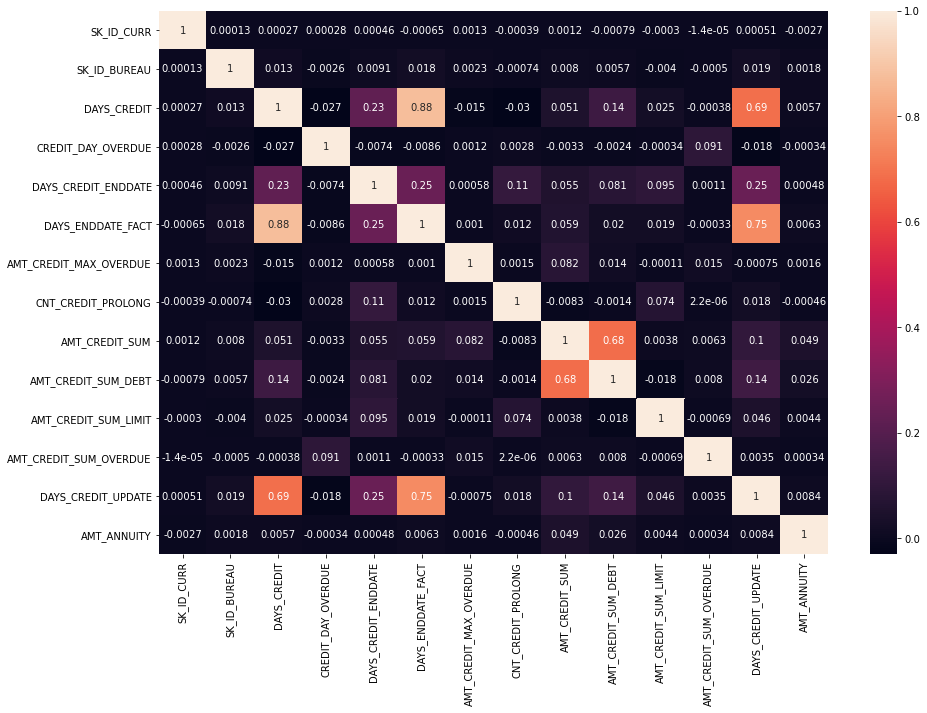

In [21]:
#correlation
plt.figure(figsize=(15, 10))
sns.heatmap(bureau.corr(), annot=True) 

In [22]:
bureau_bal = pd.read_csv("/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/bureau_balance.csv")
print('Bureau Balance shape: ', bureau_bal.shape)
bureau_bal.head(2)

Bureau Balance shape:  (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C


In [23]:
bureau_bal.describe(include='all')  

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
count,2.729992e+07,2.729992e+07,27299925
unique,NaN,NaN,8
top,NaN,NaN,C
freq,NaN,NaN,13646993
mean,6.036297e+06,-3.074169e+01,NaN
std,4.923489e+05,2.386451e+01,NaN
min,5.001709e+06,-9.600000e+01,NaN
25%,5.730933e+06,-4.600000e+01,NaN
50%,6.070821e+06,-2.500000e+01,NaN
75%,6.431951e+06,-1.100000e+01,NaN


In [24]:
bureau_bal.duplicated().sum()

0

### 2nd branche

In [25]:
pre_appli = pd.read_csv("/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/previous_application.csv")
print('Previous Application shape: ', pre_appli.shape)
pre_appli.head(2)

Previous Application shape:  (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0


In [26]:
pre_appli.describe(include='all')  

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1670214,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1670214,1.670214e+06,...,1670214,1.297984e+06,1670214,1669868,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
unique,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,7,NaN,...,11,NaN,5,17,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,NaN,NaN,NaN,NaN,NaN,TUESDAY,NaN,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,747553,NaN,NaN,NaN,NaN,NaN,255118,NaN,...,855720,NaN,517215,285990,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.923089e+06,2.783572e+05,NaN,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,NaN,1.248418e+01,...,NaN,1.605408e+01,NaN,NaN,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,NaN,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,NaN,3.334028e+00,...,NaN,1.456729e+01,NaN,NaN,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,NaN,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,NaN,0.000000e+00,...,NaN,0.000000e+00,NaN,NaN,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,NaN,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,NaN,1.000000e+01,...,NaN,6.000000e+00,NaN,NaN,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,NaN,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,NaN,1.200000e+01,...,NaN,1.200000e+01,NaN,NaN,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,NaN,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,NaN,1.500000e+01,...,NaN,2.400000e+01,NaN,NaN,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000


In [27]:
pre_appli.duplicated().sum()

0

In [28]:
pos_cash_bal = pd.read_csv("/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/POS_CASH_balance.csv")
print('POS CASH balance shape: ', pos_cash_bal.shape)
pos_cash_bal.head(2)

POS CASH balance shape:  (10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0


In [29]:
pos_cash_bal.describe(include='all')  

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,10001358,1.000136e+07,1.000136e+07
unique,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,9151119,NaN,NaN
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,NaN,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,NaN,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,NaN,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,NaN,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,NaN,0.000000e+00,0.000000e+00


In [30]:
pos_cash_bal.duplicated().sum()

0

In [31]:
inst_paym = pd.read_csv("/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/installments_payments.csv")
print('Installments Payments shape: ', inst_paym.shape)
inst_paym.head(2)

Installments Payments shape:  (13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525


In [32]:
inst_paym.describe(include='all')  

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


In [33]:
inst_paym.duplicated().sum()

0

In [34]:
cc_bal = pd.read_csv("/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/credit_card_balance.csv")
print('Credit Card Balance shape: ', cc_bal.shape)
cc_bal.head(2)

Credit Card Balance shape:  (3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0


In [35]:
cc_bal.describe(include='all')  

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3840312,3.840312e+06,3.840312e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3698436,NaN,NaN
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,...,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,NaN,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,...,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,NaN,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,NaN,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,NaN,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,NaN,0.000000e+00,0.000000e+00


In [36]:
cc_bal.duplicated().sum()

0

<AxesSubplot:>

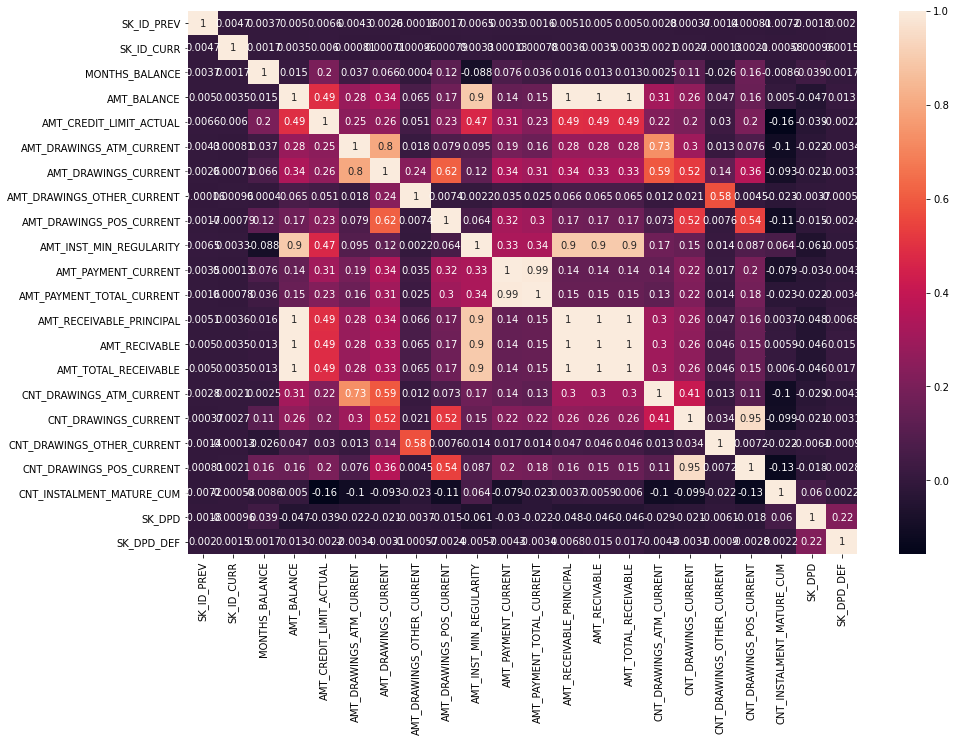

In [37]:
#correlation
plt.figure(figsize=(15, 10))
sns.heatmap(cc_bal.corr(), annot=True) 

* La corrélation entre AMT_BALANCE et AMT_INST_MIN_REGULARITY est élevé =0.9;
* La corrélation entre AMT_BALANCE et AMT_RECEIVABLE_PRINCIPAL et AMT_RECEIVABLE et AMT_TOTAL_RECEIVABLE) est très élevé =1;
* La corrélation entre AMT_DRAWING_ATM_CURRENT et AMT_DRAWINGS_CURRENT (=0.8) et CNT_DRAWINGS_CURRENT(=0.73) est très élevé;
* La corrélation entre AMT_DRAWING_CURRENT et AMT_DRAWING_POS_CURRENT (=0.62) et CNT_DRAWING_ATM_CURRENT(=0.59) est  élevé;
* La corrélation entre AMT_INST_MIN_REGULARITY et AMT_RECEIVABLE_PRINCIPAL et AMT_RECEIVABLE et AMT_TOTAL_RECEIVABLE) est très élevé =0.9;
* La corrélation entre AMT_PAYMENT_CURRENT et AMT_PAYMENT_TOTAL_CURRENT est très élevé =0.99;
* La corrélation entre CNT_DRAWING_POS_CURRENT et CNT_DRAWINGS_CURRENT(=0.95) est très élevé;

#### Fichier de description des data

In [38]:
homecredit_desc = pd.read_csv("/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/HomeCredit_columns_description.csv")
print('HomeCredit columns description shape: ', homecredit_desc.shape)
homecredit_desc.head(2)

HomeCredit columns description shape:  (219, 5)


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN


In [39]:
homecredit_desc.duplicated().sum()

0

In [40]:
#exporter dans un tableur pour lire les descriptions
homecredit_desc.to_csv("homecredit_description_colonnes.csv", sep='\t')

In [41]:
samp_sub = pd.read_csv("/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/sample_submission.csv")
print('Sample Submission shape: ', samp_sub.shape)
samp_sub.head(2)

Sample Submission shape:  (48744, 2)


,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5


In [42]:
samp_sub.describe(include='all')  

,SK_ID_CURR,TARGET
count,48744.000000,48744.0
mean,277796.676350,0.5
std,103169.547296,0.0
min,100001.000000,0.5
25%,188557.750000,0.5
50%,277549.000000,0.5
75%,367555.500000,0.5
max,456250.000000,0.5


In [43]:
samp_sub.duplicated().sum()

0

### Analyse Exploratoire des données (EDA)

##### [Table of Contents](#table1)

On va analyser `application_train`

In [44]:
appli_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:>

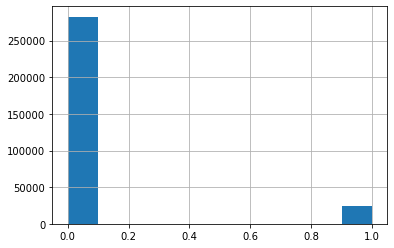

In [45]:
appli_train.TARGET.hist()

Pour information, on a deux classes pour la `TARGET` variable:
- 1 = client en difficulté de paiement : il a eu un retard de paiement de plus de X jours sur au moins une des Y premières échéances du crédit de notre échantillon;
- 0 = tous les autres cas;
On peut observer qu'il s'agit d'un problème de classe déséquilibré (**Imbalanced Classe**) . Il y a beaucoup plus de prêts qui n'ont pas eu de problème de paiement que de prêts qui ont eu des diffilculté de paiement été. ce problème avec des classes déséquilibrées en machine learning, peut être résolu en pondérant (**weight the classes**) les classes (représentation des données).

### Resampling
Dans le cas de données très déséquilibré comme ici, il existe des techniques de rééchantillonnage afin de rééquilibrer ces données. Pour cela nous allons utiliser la librairie `imblearn`.

Il existe deux techniques pour resampler les données :

- L'under-sampling : On supprime des individus de la classe majoritaire.
> Under-sampling:
Les Tomek links sont des paires d'instances très proches, mais de classes opposées. La suppression des instances de la classe majoritaire de chaque paire augmente l'espace entre les deux classes, facilitant le processus de classification.
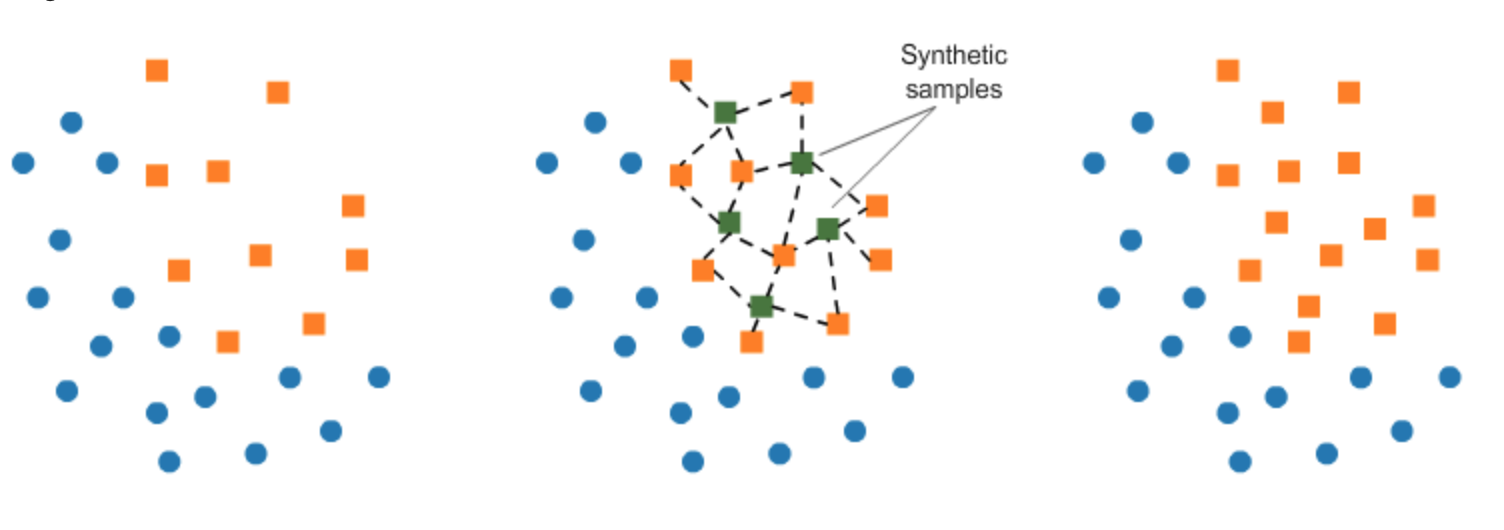
- L'over-sampling : On crée des individus dans la classe minoritaire.
> Over-sampling :
consiste à synthétiser des éléments pour la classe minoritaire, à partir de ceux qui existent déjà. Cela fonctionne en choisissant aléatoirement un point de la classe minoritaire et en calculant les k plus proches voisins pour ce point. Les points synthétiques sont ajoutés entre le point choisi et ses voisins.
![Capture%20d%E2%80%99e%CC%81cran%202022-11-26%20a%CC%80%2000.27.17.png](attachment:Capture%20d%E2%80%99e%CC%81cran%202022-11-26%20a%CC%80%2000.27.17.png)

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
Pourcentages
F      65.834393
M      34.164306
XNA     0.001301
Name: CODE_GENDER, dtype: float64


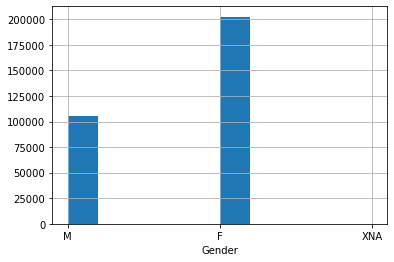

In [46]:
appli_train['CODE_GENDER'].hist()
plt.xlabel('Gender');
print(appli_train['CODE_GENDER'].value_counts())
print("Pourcentages")
print((appli_train['CODE_GENDER'].value_counts()/len(appli_train['CODE_GENDER']))*100)

> On observe qu'on a plus de femme (65%) qui emprunte que d'homme (34%). On a 4 valeurs de genre XNA. On va les supprimer, cela n'aura peu d'impact sur notre modèle.

In [47]:
# On va supprimer "XNA" de "application_train"
appli_train = appli_train[appli_train['CODE_GENDER'] != 'XNA']

N    202922
Y    104585
Name: FLAG_OWN_CAR, dtype: int64
Pourcentages
N    65.989392
Y    34.010608
Name: FLAG_OWN_CAR, dtype: float64


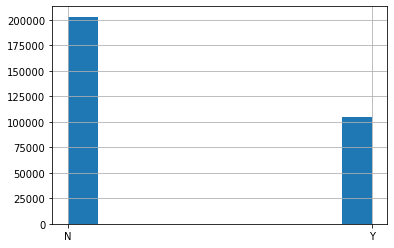

In [48]:
appli_train['FLAG_OWN_CAR'].hist()
print(appli_train['FLAG_OWN_CAR'].value_counts())
print("Pourcentages")
print((appli_train['FLAG_OWN_CAR'].value_counts()/len(appli_train['FLAG_OWN_CAR']))*100)

> On observe qu'un peu plus d'un tiers des emprunteurs (34%) sont propriétaires de leurs voitures.

Y    213308
N     94199
Name: FLAG_OWN_REALTY, dtype: int64


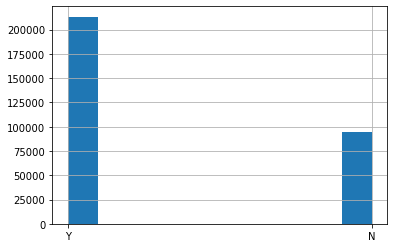

In [49]:
appli_train['FLAG_OWN_REALTY'].hist()
print(appli_train['FLAG_OWN_REALTY'].value_counts())

> On observe qu'un peu moins d'un tiers des emprunteurs ne sont pas propriétaires d'une maison ou d'un appartement.

In [50]:
#Combien de jours avant la demande, la personne a commencé son emploi actuel
appli_train['DAYS_EMPLOYED'].describe()

count    307507.000000
mean      63815.929208
std      141276.472519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 1.0, 'Days Employed')

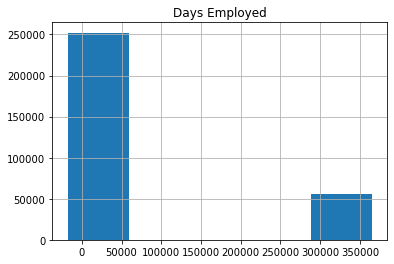

In [51]:
appli_train['DAYS_EMPLOYED'].hist(bins=5).set_title('Days Employed')

> La valeur max est positive et correspond à 365243 jours soit environ 1000 ans. la valeur est aberrante (Outlier).

In [52]:
# Âge du client en jours au moment de la demande
appli_train['DAYS_BIRTH'].describe()

count    307507.000000
mean     -16037.027271
std        4363.982424
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

> L'age des emprunteur semble correct. Elle varie de max à environs 20 ans à min à environs 69 ans. à 50%, on est à 43 ans environs. On constate que ces nombres sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. On doit modifier cette variable afin qu'elle soit pertinente pour notre analyse.

In [53]:
(appli_train['DAYS_BIRTH'] / -365).describe()

count    307507.000000
mean         43.937061
std          11.956116
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Text(0.5, 1.0, 'Age of client')

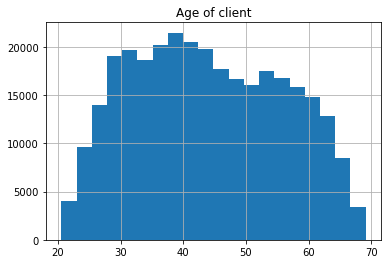

In [54]:
(appli_train['DAYS_BIRTH'] / -365).hist(bins=20).set_title('Age of client')

Working                 158771
Commercial associate     71616
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64


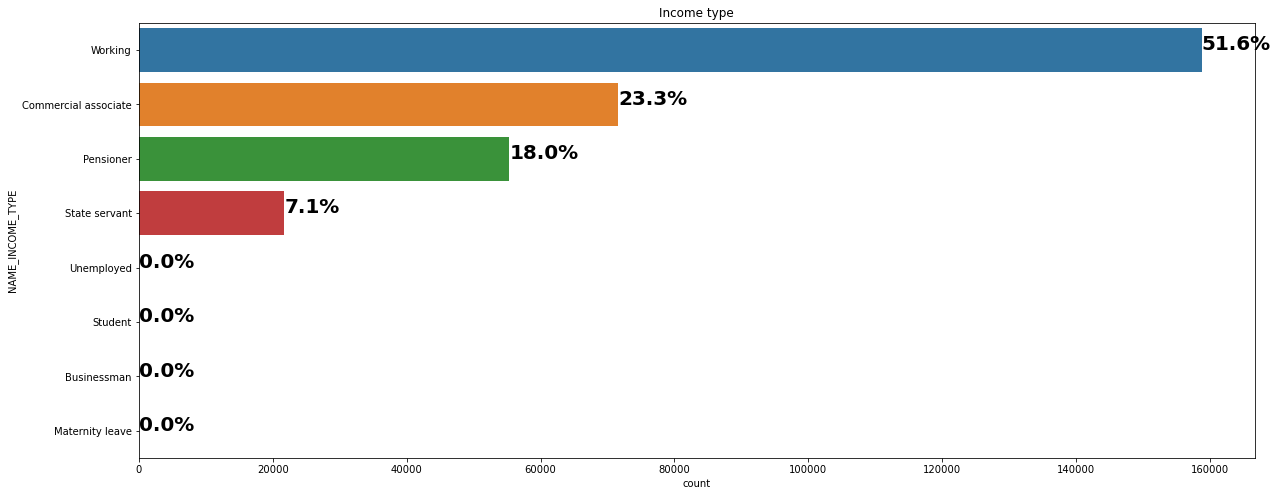

In [55]:
# Type de revenu des clients
print(appli_train['NAME_INCOME_TYPE'].value_counts())
ax, fig = plt.subplots(figsize=(20,8)) 
ax = sns.countplot(y="NAME_INCOME_TYPE", data=appli_train, order=appli_train["NAME_INCOME_TYPE"].value_counts(ascending=False).index)
ax.set_title("Income type")
for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(appli_train["NAME_INCOME_TYPE"]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

> La majorité des demandeurs de prêts ont un type de revenu issue du **travail (51.6%)**, puis du type de revenu issue d'**associé commercial (23.3%)**, puis du type de revenu issue de la **retraite (18%)** et du type de revenu issue d'un emploi de **fonctionnaire (7.1%)**.

Laborers                 55186
Sales staff              32102
Core staff               27569
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2092
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64


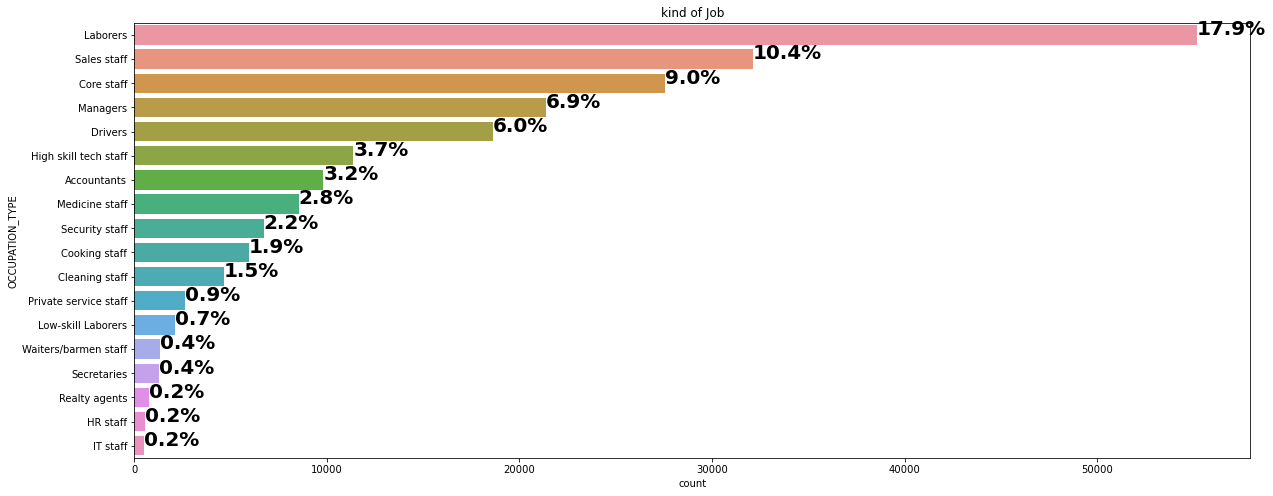

In [56]:
# Type de métiers des clients
print(appli_train['OCCUPATION_TYPE'].value_counts())
ax, fig = plt.subplots(figsize=(20,8)) 
ax = sns.countplot(y="OCCUPATION_TYPE", data=appli_train, order=appli_train["OCCUPATION_TYPE"].value_counts(ascending=False).index)
ax.set_title("kind of Job")
for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(appli_train["OCCUPATION_TYPE"]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

> La majorité des demandeurs de prêts sont issues du métier d'**ouvriers (17.9%)**, puis du métier de **vendeurs (10.4%)**, puis du métier de **personnel (9%)**, puis du métier de **managers (6.9%)** et du métier de **chauffeurs (6%)** .

In [57]:
# Revenu du client
appli_train['AMT_INCOME_TOTAL'].describe()

count    3.075070e+05
mean     1.687977e+05
std      2.371246e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

Text(0.5, 1.0, 'Customer Income')

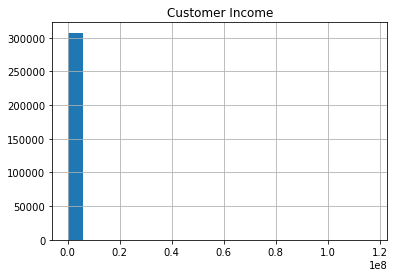

In [58]:
#print(appli_train['AMT_INCOME_TOTAL'].value_counts())
appli_train['AMT_INCOME_TOTAL'].hist(bins=20).set_title('Customer Income')

> Le revenu des clients sont dans un interval correct de revenu annuel entre 25650 (min) à 202500 (75%) à 117 millions (max). La valeur max semble être une valeur aberrante;

In [59]:
# Montant du crédit du prêt
appli_train['AMT_CREDIT'].describe()

count    3.075070e+05
mean     5.990286e+05
std      4.024926e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

> Le montant du crédit du prêt sont dans un interval de coût entre 45.000 (min) à 808.650 (75%) à 4.050.000 (max). La valeur max semble être une valeur aberrante;

(<matplotlib.legend.Legend at 0x7f819f7fbdf0>,
 Text(0.5, 0, 'Montant du crédit du prêt'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Credit Distribution'))

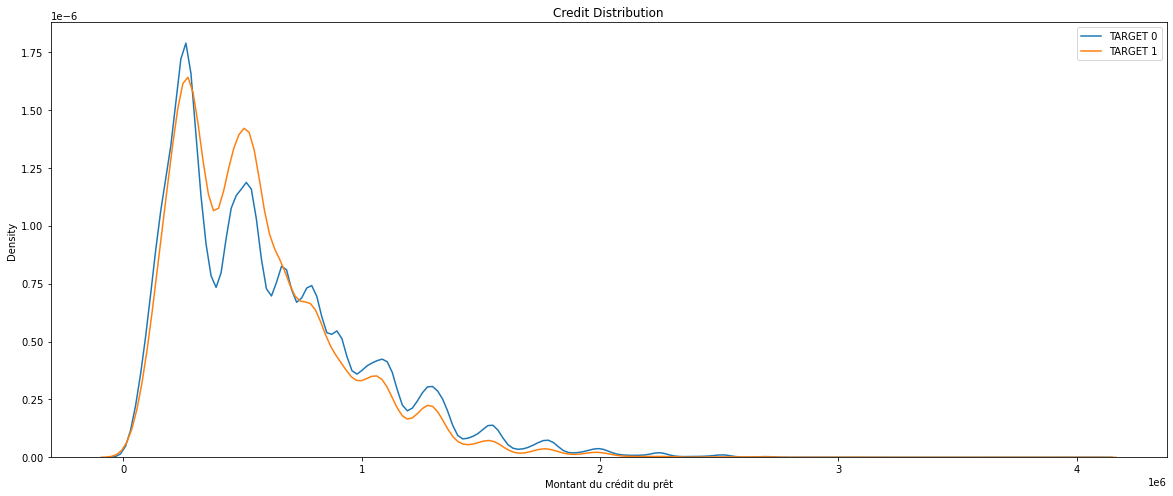

In [60]:
## Distribution du montant du crédit en fonction de la Target
plt.figure(figsize = (20, 8))
sns.kdeplot(appli_train[appli_train['TARGET'] == 0]['AMT_CREDIT'], label = 'TARGET 0')
sns.kdeplot(appli_train[appli_train['TARGET'] == 1]['AMT_CREDIT'], label = 'TARGET 1')

plt.legend(), plt.xlabel('Montant du crédit du prêt'), plt.ylabel('Density'), plt.title('Credit Distribution')

Married                 196429
Single / not married     45444
Civil marriage           29774
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64


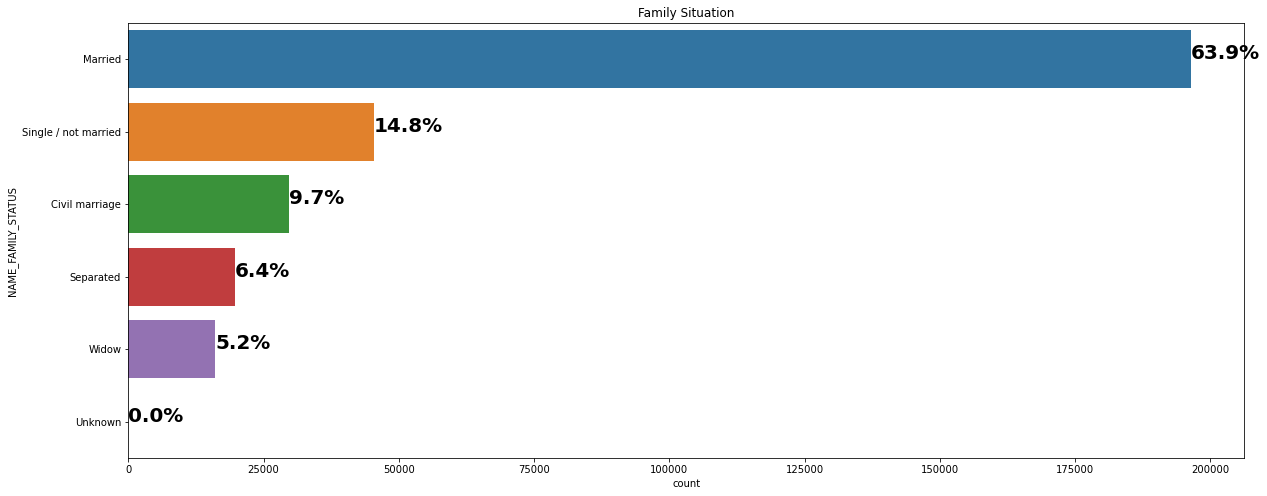

In [61]:
# Situation familiale des clients
print(appli_train['NAME_FAMILY_STATUS'].value_counts())
ax, fig = plt.subplots(figsize=(20,8)) 
ax = sns.countplot(y="NAME_FAMILY_STATUS", data=appli_train, order=appli_train["NAME_FAMILY_STATUS"].value_counts(ascending=False).index)
ax.set_title("Family Situation")
for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(appli_train["NAME_FAMILY_STATUS"]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

> La majorité des clients sont **mariés (64%)**, puis ce sont des **célibataires ou non mariés (15%)**, en troisième position ce sont les clients issues de **mariages civils (10%)**, en quatrième position ce sont les clients **séparés (6.4%)**, en cinquième position ce sont les **veuves (5.2%)** et en dernière position ce sont les situations familiales **inconnues (0.001%)**.

In [62]:
# Combien de membres de la famille le client a-t-il
appli_train['CNT_FAM_MEMBERS'].describe()

count    307505.000000
mean          2.152658
std           0.910680
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: CNT_FAM_MEMBERS, dtype: float64

[ 1.  2.  3.  4.  5.  6.  9.  7.  8. 10. 13. nan 14. 12. 20. 15. 16. 11.]


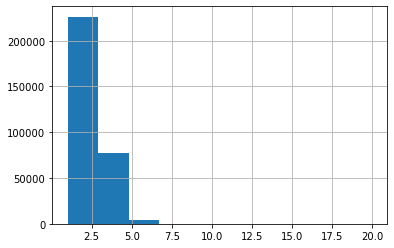

In [63]:
appli_train['CNT_FAM_MEMBERS'].hist()
print(appli_train['CNT_FAM_MEMBERS'].unique())

> Le nombre de membre dans la famille de l'emprunteur semble correct. Elle varie de max. à 20 membres à min. à  1 membre. à 75%, on a 3 membres dans la famille. La valeur max. est un outlier.

In [64]:
# Rente de prêt
appli_train['AMT_ANNUITY'].describe()

count    307495.000000
mean      27108.666786
std       14493.798379
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64

> La rente de prêt varie de max. à environs 258025.5, et à min., on a 1615,5. A 50%, on est à 24903;

(<matplotlib.legend.Legend at 0x7f819f6ffb80>,
 Text(0.5, 0, 'Rente de Prêt'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Annuity Distribution'))

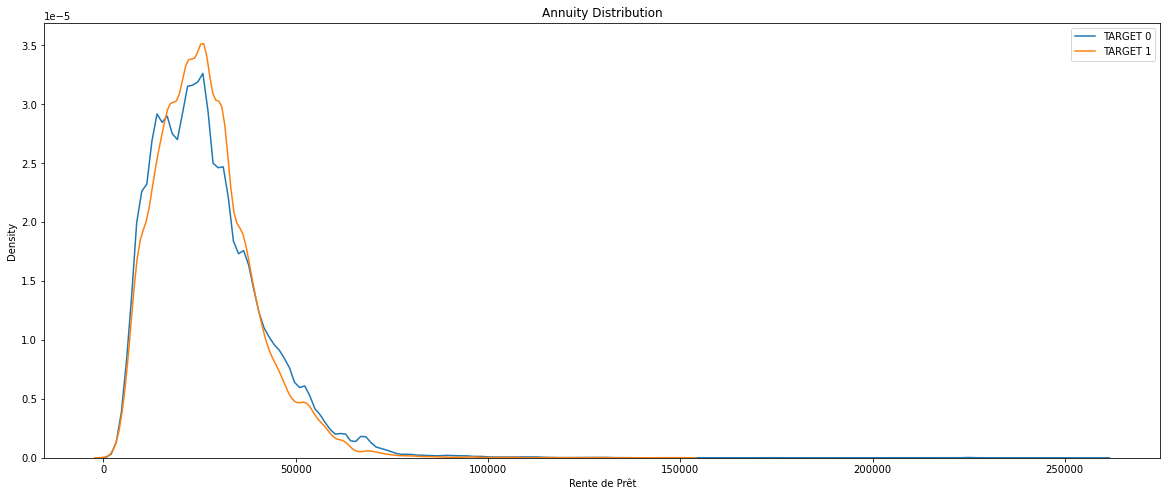

In [65]:
# Distribution de la rente de prêt en fonction de la Target
plt.figure(figsize = (20, 8))
sns.kdeplot(appli_train[appli_train['TARGET'] == 0]['AMT_ANNUITY'], label = 'TARGET 0')
sns.kdeplot(appli_train[appli_train['TARGET'] == 1]['AMT_ANNUITY'], label = 'TARGET 1')

plt.legend(), plt.xlabel('Rente de Prêt'), plt.ylabel('Density'), plt.title('Annuity Distribution')

(<matplotlib.legend.Legend at 0x7f81a037b3a0>,
 Text(0.5, 0, 'Jours Avant Modification'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Days Registration Distribution'))

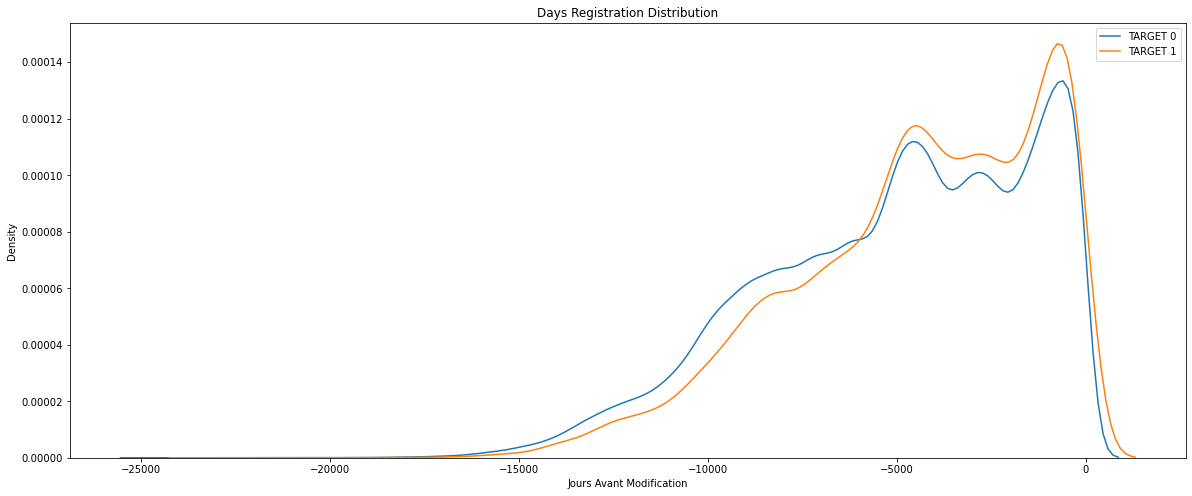

In [66]:
# Distribution de la rente de prêt en fonction de la Target
plt.figure(figsize = (20, 8))
sns.kdeplot(appli_train[appli_train['TARGET'] == 0]['DAYS_REGISTRATION'], label = 'TARGET 0')
sns.kdeplot(appli_train[appli_train['TARGET'] == 1]['DAYS_REGISTRATION'], label = 'TARGET 1')

plt.legend(), plt.xlabel('Jours Avant Modification'), plt.ylabel('Density'), plt.title('Days Registration Distribution')

(<matplotlib.legend.Legend at 0x7f819f7ae430>,
 Text(0.5, 0, 'Prix des Biens'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Goods Price Distribution'))

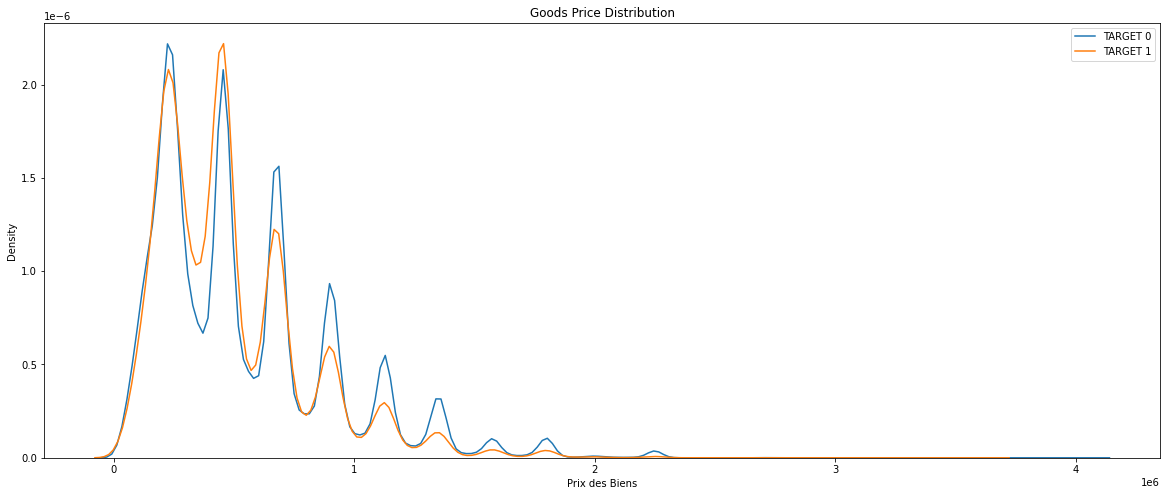

In [67]:
# Distribution des prix des biens en fonction de la Target
plt.figure(figsize = (20, 8))
sns.kdeplot(appli_train[appli_train['TARGET'] == 0]['AMT_GOODS_PRICE'], label = 'TARGET 0')
sns.kdeplot(appli_train[appli_train['TARGET'] == 1]['AMT_GOODS_PRICE'], label = 'TARGET 1')

plt.legend(), plt.xlabel('Prix des Biens'), plt.ylabel('Density'), plt.title('Goods Price Distribution')

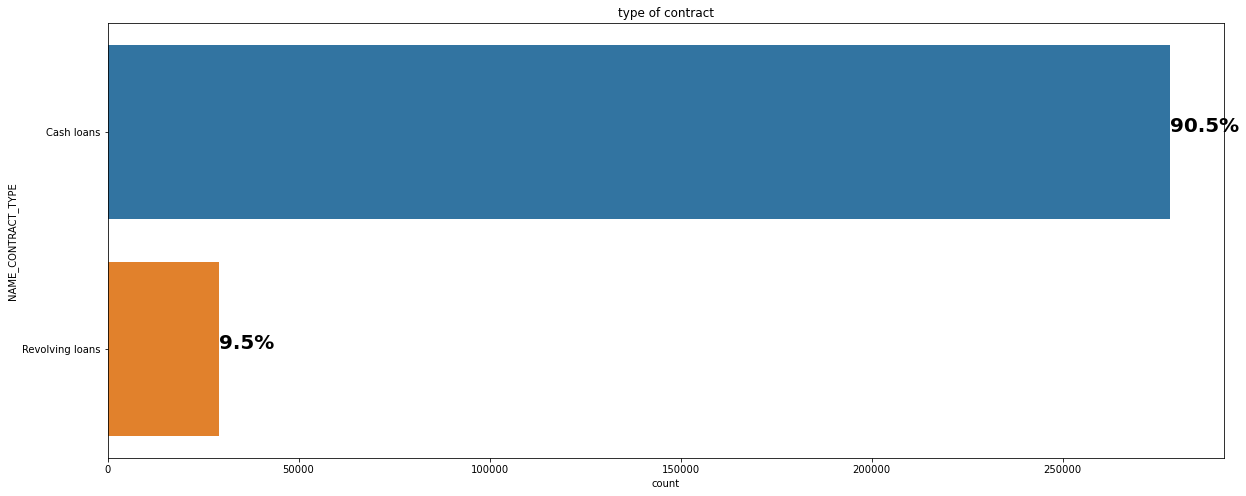

In [68]:
# Types de contrat
ax, fig = plt.subplots(figsize=(20,8)) 
ax = sns.countplot(y="NAME_CONTRACT_TYPE", data=appli_train, order=appli_train["NAME_CONTRACT_TYPE"].value_counts(ascending=False).index)
ax.set_title("type of contract")
for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(appli_train["NAME_CONTRACT_TYPE"]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

> Les prêts renouvelables (revolving loans) représentent environ 10% du nombre total de prêts;

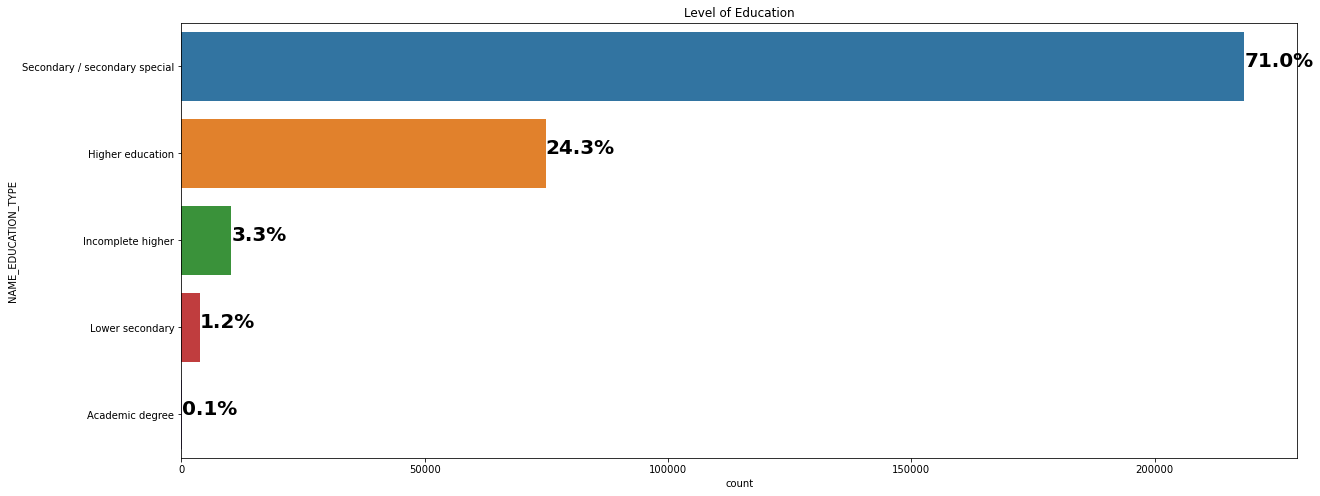

In [69]:
# Niveau d'éducation des clients
ax, fig = plt.subplots(figsize=(20,8)) 
ax = sns.countplot(y="NAME_EDUCATION_TYPE", data=appli_train, order=appli_train["NAME_EDUCATION_TYPE"].value_counts(ascending=False).index)
ax.set_title("Level of Education")
for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(appli_train["NAME_EDUCATION_TYPE"]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

> La majorité des demandeurs de prêts ont eu une éducation dans l'**éducation secondaire(71%)**, puis ceux ayant une **éducation supérieure(24.3%)**, puis ceux ayant une **éducation supérieure mais pas terminée(3.3%)**, puis ceux ayant une **éducation au collège (1.2%)**, et une faible partie ont un **diplôme universitaire(0.1%)**.

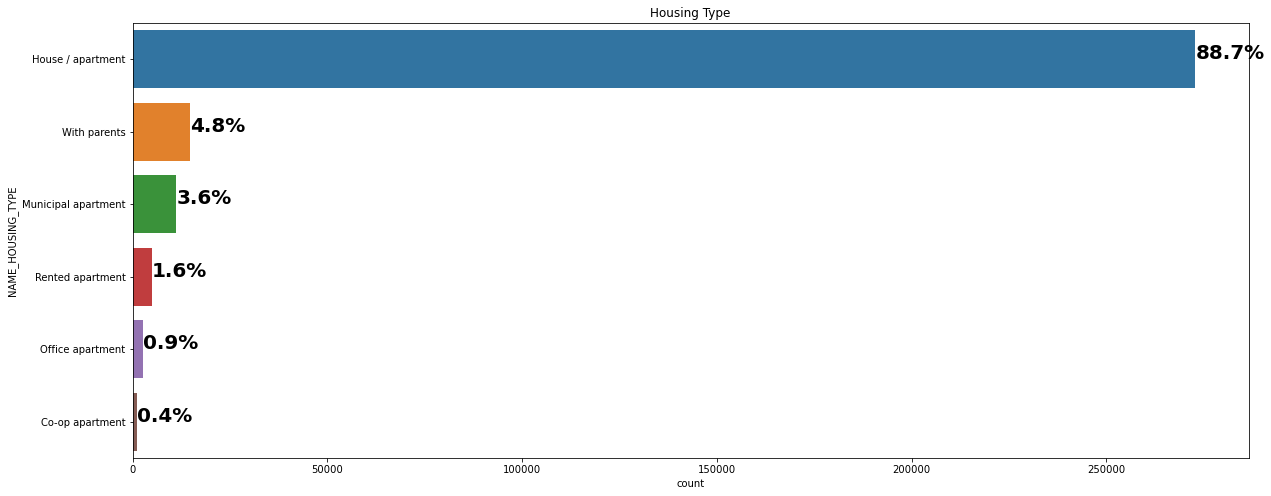

In [70]:
# Type de logement des clients
ax, fig = plt.subplots(figsize=(20,8)) 
ax = sns.countplot(y="NAME_HOUSING_TYPE", data=appli_train, order=appli_train["NAME_HOUSING_TYPE"].value_counts(ascending=False).index)
ax.set_title("Housing Type")
for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(appli_train["NAME_HOUSING_TYPE"]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

> La majorité des demandeurs de prêts ont une **maison ou appartement(88.7%)**, puis ceux habitant avec leur **parents(4.8%)**, puis ceux ayant un **appartement municipal(3.6%)**, puis ceux louant un **appartement (1.6%)**, puis ceux ayant un **appartement de bureau (0.9%)**,et une faible partie vivant en **colocation(0.4%)**.

In [71]:
#coefficient Pearson de la variable "DAYS_BIRTH" avec la variable "TARGET"
#On transforme le nombre de jours depuis la naissance (négatifs) en âges (positif)
appli_train['TARGET'].corr(appli_train['DAYS_BIRTH']/-365)

-0.07824216003619364

> On peut traduire cela qu'un client plus âgé fera moins défaut dans le remboursement de son prêt.

(<matplotlib.legend.Legend at 0x7f819ea111c0>,
 Text(0.5, 0, 'Age(years)'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Age Distribution'))

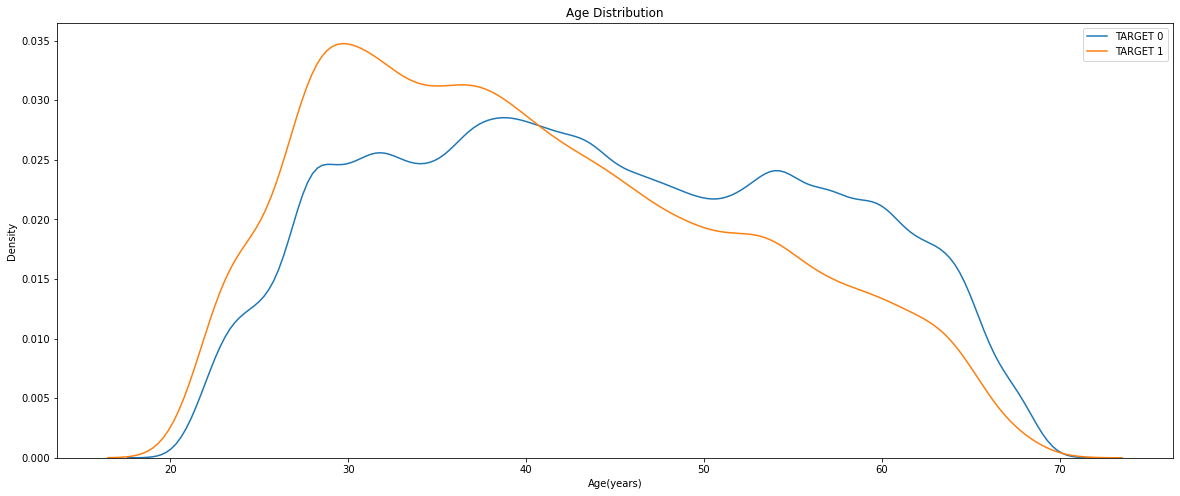

In [72]:
# Distribution de l'âge en fonction de la Target
plt.figure(figsize = (20, 8))
sns.kdeplot(appli_train[appli_train['TARGET'] == 0]['DAYS_BIRTH'] / -365, label = 'TARGET 0')
sns.kdeplot(appli_train[appli_train['TARGET'] == 1]['DAYS_BIRTH'] / -365, label = 'TARGET 1')

plt.legend(), plt.xlabel('Age(years)'), plt.ylabel('Density'), plt.title('Age Distribution')

> La courbe TARGET 1 augmente jusqu'autour de 30 ans et diminue progressivement jusqu'aux clients les plus âgés. Les clients les plus âgés feraient moins défaut dans le remboursement de son prêt. La variable "DAYS_BIRTH" semble être corréler à "TARGET".

### Features Engineering

In [73]:
#Application train/test

[0.06732903 0.07086191 0.0118135  ... 0.52926634 0.40013377 0.07486948]


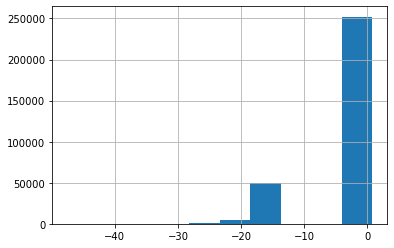

In [74]:
# Nombre de jour travaillé suivant son age avant la demande prêt (en%)
appli_train['DAYS_EMPLOYED_PERC'] = (appli_train['DAYS_EMPLOYED'] / appli_train['DAYS_BIRTH'])
appli_train['DAYS_EMPLOYED_PERC'].hist()
print(appli_train['DAYS_EMPLOYED_PERC'].unique())

[0.49803553 0.20873558 0.5        ... 0.15090198 0.20018223 0.46202855]


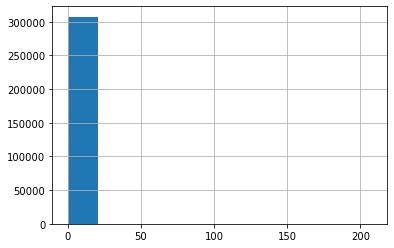

In [75]:
appli_train['INCOME_CREDIT_PERC'] = (appli_train['AMT_INCOME_TOTAL'] / appli_train['AMT_CREDIT'])
appli_train['INCOME_CREDIT_PERC'].hist()
print(appli_train['INCOME_CREDIT_PERC'].unique())

[202500.   135000.    67500.   ...  49178.25  48384.   273125.25]


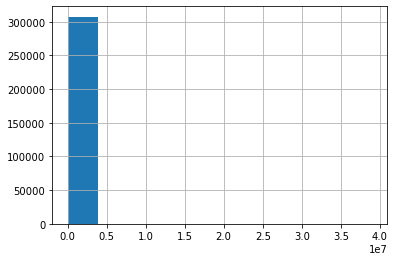

In [76]:
appli_train['INCOME_PER_PERSON'] = (appli_train['AMT_INCOME_TOTAL'] / appli_train['CNT_FAM_MEMBERS'])
appli_train['INCOME_PER_PERSON'].hist()
print(appli_train['INCOME_PER_PERSON'].unique())

[0.12197778 0.13221667 0.1        ... 0.13786207 0.10520588 0.19594118]


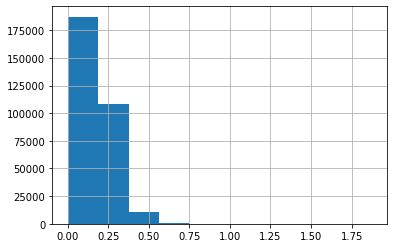

In [77]:
appli_train['ANNUITY_INCOME_PERC'] = (appli_train['AMT_ANNUITY'] / appli_train['AMT_INCOME_TOTAL'])
appli_train['ANNUITY_INCOME_PERC'].hist()
print(appli_train['ANNUITY_INCOME_PERC'].unique())

[0.06074927 0.02759832 0.05       ... 0.06408769 0.03591689 0.05583805]


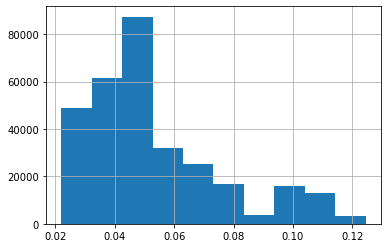

In [78]:
appli_train['PAYMENT_RATE'] = (appli_train['AMT_ANNUITY'] / appli_train['AMT_CREDIT'])
appli_train['PAYMENT_RATE'].hist()
print(appli_train['PAYMENT_RATE'].unique())

In [79]:
# bureau & bureau_balance

[5714462 5714463 5714464 ... 5057762 5057770 5057778]


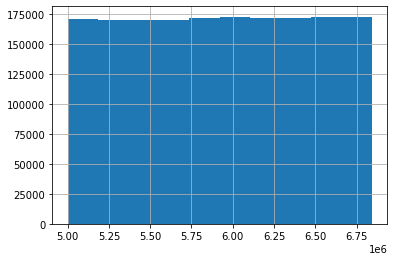

In [80]:
bureau['SK_ID_BUREAU'].hist()
print(bureau['SK_ID_BUREAU'].unique())

count    1.716428e+06
mean    -1.142108e+03
std      7.951649e+02
min     -2.922000e+03
25%     -1.666000e+03
50%     -9.870000e+02
75%     -4.740000e+02
max      0.000000e+00
Name: DAYS_CREDIT, dtype: float64


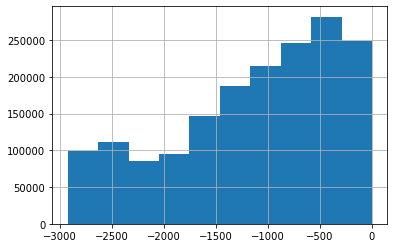

In [81]:
#Combien de jours avant la demande actuelle, le client a-t-il demandé un crédit au bureau de crédit
bureau['DAYS_CREDIT'].hist()
print(bureau['DAYS_CREDIT'].describe())

count    1.610875e+06
mean     5.105174e+02
std      4.994220e+03
min     -4.206000e+04
25%     -1.138000e+03
50%     -3.300000e+02
75%      4.740000e+02
max      3.119900e+04
Name: DAYS_CREDIT_ENDDATE, dtype: float64


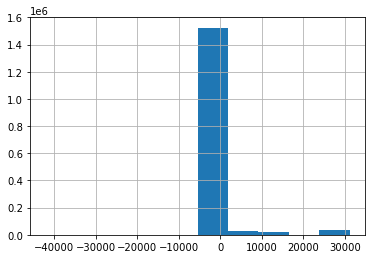

In [82]:
# Durée restante du crédit CB (en jours) au moment de la demande en Crédit Immobilier
bureau['DAYS_CREDIT_ENDDATE'].hist()
print(bureau['DAYS_CREDIT_ENDDATE'].describe())

count    1.716428e+06
mean    -5.937483e+02
std      7.207473e+02
min     -4.194700e+04
25%     -9.080000e+02
50%     -3.950000e+02
75%     -3.300000e+01
max      3.720000e+02
Name: DAYS_CREDIT_UPDATE, dtype: float64


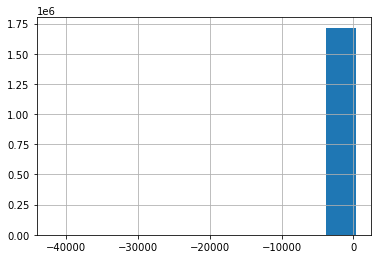

In [83]:
# Combien de jours avant la demande de prêt les dernières informations sur le crédit du bureau de crédit 
# sont-elles arrivées
bureau['DAYS_CREDIT_UPDATE'].hist()
print(bureau['DAYS_CREDIT_UPDATE'].describe())

count    1.716428e+06
mean     8.181666e-01
std      3.654443e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.792000e+03
Name: CREDIT_DAY_OVERDUE, dtype: float64


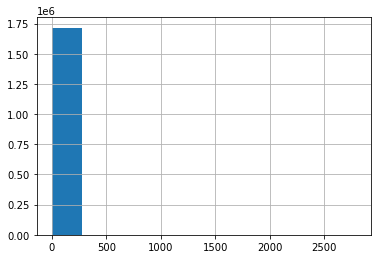

In [84]:
# Nombre de jours d'impayés sur crédit CB au moment de la demande de prêt connexe dans notre échantillon
bureau['CREDIT_DAY_OVERDUE'].hist()
print(bureau['CREDIT_DAY_OVERDUE'].describe())

count    5.919400e+05
mean     3.825418e+03
std      2.060316e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.159872e+08
Name: AMT_CREDIT_MAX_OVERDUE, dtype: float64


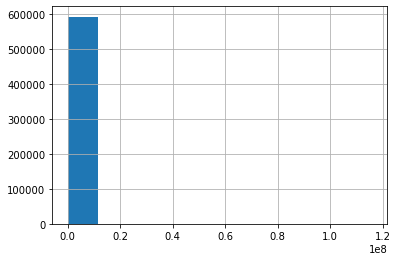

In [85]:
# Montant maximal en souffrance sur le crédit du bureau de crédit jusqu'à présent 
# (à la date de demande de prêt dans notre échantillon)
bureau['AMT_CREDIT_MAX_OVERDUE'].hist()
print(bureau['AMT_CREDIT_MAX_OVERDUE'].describe())

count    1.716415e+06
mean     3.549946e+05
std      1.149811e+06
min      0.000000e+00
25%      5.130000e+04
50%      1.255185e+05
75%      3.150000e+05
max      5.850000e+08
Name: AMT_CREDIT_SUM, dtype: float64


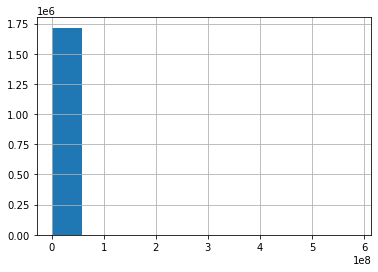

In [86]:
# Montant actuel du crédit pour le crédit du bureau de crédit
bureau['AMT_CREDIT_SUM'].hist()
print(bureau['AMT_CREDIT_SUM'].describe())

count    1.458759e+06
mean     1.370851e+05
std      6.774011e+05
min     -4.705600e+06
25%      0.000000e+00
50%      0.000000e+00
75%      4.015350e+04
max      1.701000e+08
Name: AMT_CREDIT_SUM_DEBT, dtype: float64


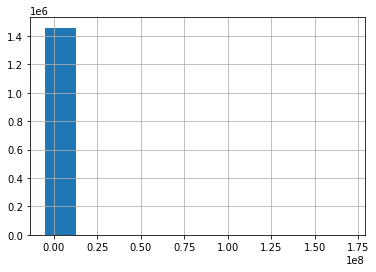

In [87]:
# Dette actuelle sur le crédit du Bureau de crédit
bureau['AMT_CREDIT_SUM_DEBT'].hist()
print(bureau['AMT_CREDIT_SUM_DEBT'].describe())

count    1.716428e+06
mean     3.791276e+01
std      5.937650e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.756681e+06
Name: AMT_CREDIT_SUM_OVERDUE, dtype: float64


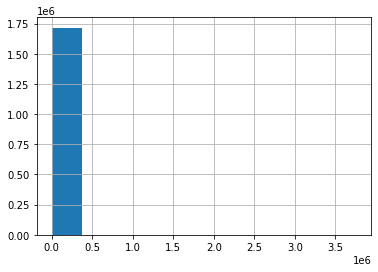

In [88]:
# Montant actuel en souffrance sur le crédit du bureau de crédit
bureau['AMT_CREDIT_SUM_OVERDUE'].hist()
print(bureau['AMT_CREDIT_SUM_OVERDUE'].describe())

count    1.124648e+06
mean     6.229515e+03
std      4.503203e+04
min     -5.864061e+05
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.705600e+06
Name: AMT_CREDIT_SUM_LIMIT, dtype: float64


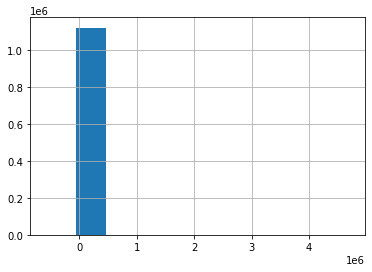

In [89]:
# Limite de crédit actuelle de la carte de crédit signalée au bureau de crédit
bureau['AMT_CREDIT_SUM_LIMIT'].hist()
print(bureau['AMT_CREDIT_SUM_LIMIT'].describe())

count    4.896370e+05
mean     1.571276e+04
std      3.258269e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.350000e+04
max      1.184534e+08
Name: AMT_ANNUITY, dtype: float64


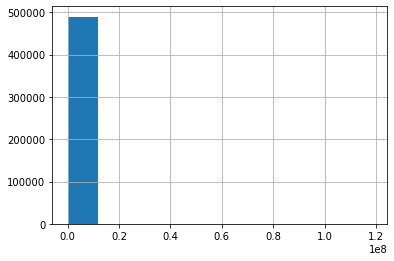

In [90]:
# Rente du Crédit Bureau de crédit
bureau['AMT_ANNUITY'].hist()
print(bureau['AMT_ANNUITY'].describe())

count    1.716428e+06
mean     6.410406e-03
std      9.622391e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.000000e+00
Name: CNT_CREDIT_PROLONG, dtype: float64
[0 2 1 4 3 5 9 8 6 7]


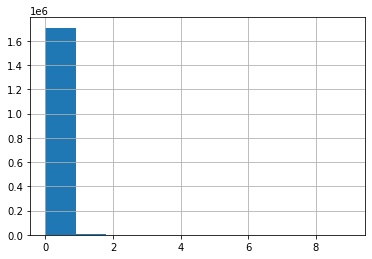

In [91]:
# Combien de fois le crédit du bureau de crédit a-t-il été prolongé
bureau['CNT_CREDIT_PROLONG'].hist()
print(bureau['CNT_CREDIT_PROLONG'].describe())
print(bureau['CNT_CREDIT_PROLONG'].unique())

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64


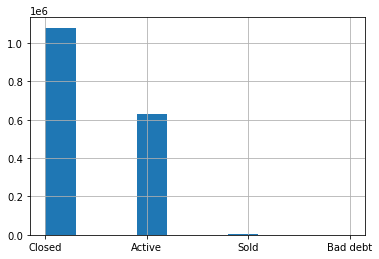

In [92]:
# Statut des crédits déclarés par la centrale des risques (CB)
bureau['CREDIT_ACTIVE'].hist()
print(bureau['CREDIT_ACTIVE'].value_counts())

In [93]:
# previous_applications

count    997149.000000
mean     342209.855039
std       88916.115834
min       -2922.000000
25%      365243.000000
50%      365243.000000
75%      365243.000000
max      365243.000000
Name: DAYS_FIRST_DRAWING, dtype: float64
 365243.0    934444
-228.0          123
-212.0          121
-224.0          121
-223.0          119
              ...  
-1544.0           1
-1887.0           1
-1579.0           1
-1733.0           1
-1895.0           1
Name: DAYS_FIRST_DRAWING, Length: 2838, dtype: int64


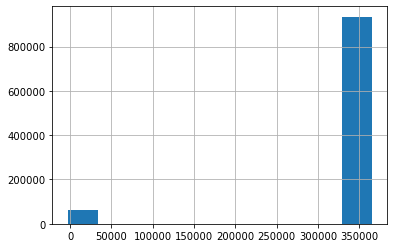

In [94]:
# Statut des crédits déclarés par la centrale des risques (CB)
pre_appli['DAYS_FIRST_DRAWING'].hist()
print(pre_appli['DAYS_FIRST_DRAWING'].describe())
print(pre_appli['DAYS_FIRST_DRAWING'].value_counts())

count     1716428
unique          4
top        Closed
freq      1079273
Name: CREDIT_ACTIVE, dtype: object
Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64


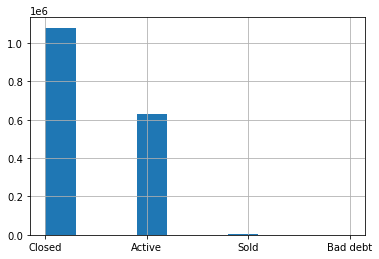

In [95]:
# Statut des crédits déclarés par la centrale des risques (CB)
bureau['CREDIT_ACTIVE'].hist()
print(bureau['CREDIT_ACTIVE'].describe())
print(bureau['CREDIT_ACTIVE'].value_counts())

count    2.729992e+07
mean    -3.074169e+01
std      2.386451e+01
min     -9.600000e+01
25%     -4.600000e+01
50%     -2.500000e+01
75%     -1.100000e+01
max      0.000000e+00
Name: MONTHS_BALANCE, dtype: float64


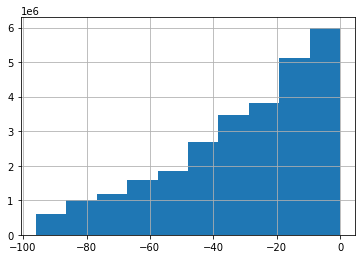

In [96]:
# Mois du solde par rapport à la date d'application (-1 signifie la date de solde la plus récente)
bureau_bal['MONTHS_BALANCE'].hist()
print(bureau_bal['MONTHS_BALANCE'].describe())
#print(bureau_bal['MONTHS_BALANCE'].value_counts())

###  previous_applications data
- On a des informations sur toutes les demandes précédentes de crédit immobilier des clients qui ont des prêts dans les données;
- On a une ligne pour chaque demande précédente liée aux prêts dans nos données. 
> On va fusionner "application_train" avec "previous_application" pour avoir la variable TARGET  et donc d'avoir l'information TARGET == 1. la variable "SK_ID_CURR" est la clé des deux datasets.

In [97]:
# On va fusionner "application_train" avec "previous_application"
appli_prev_train = appli_train.merge(pre_appli, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

count    997149.000000
mean     342209.855039
std       88916.115834
min       -2922.000000
25%      365243.000000
50%      365243.000000
75%      365243.000000
max      365243.000000
Name: DAYS_FIRST_DRAWING, dtype: float64


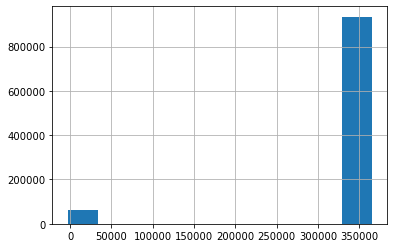

In [98]:
# Par rapport à la date d'application de l'application actuelle, à quand remonte le premier décaissement 
# de l'application précédente
pre_appli['DAYS_FIRST_DRAWING'].hist()
print(pre_appli['DAYS_FIRST_DRAWING'].describe())
#print(pre_appli['DAYS_FIRST_DRAWING'].value_counts())

count    997149.000000
mean      13826.269337
std       72444.869708
min       -2892.000000
25%       -1628.000000
50%        -831.000000
75%        -411.000000
max      365243.000000
Name: DAYS_FIRST_DUE, dtype: float64


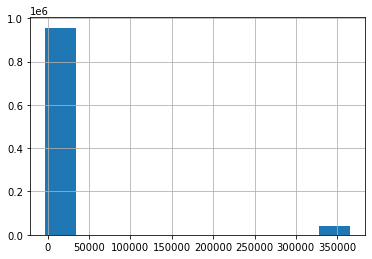

In [99]:
# Par rapport à la date de demande de la demande en cours, quand était la première échéance 
# censée être de la demande précédente
pre_appli['DAYS_FIRST_DUE'].hist()
print(pre_appli['DAYS_FIRST_DUE'].describe())
#print(pre_appli['DAYS_FIRST_DUE'].value_counts())

count    997149.000000
mean      33767.774054
std      106857.034789
min       -2801.000000
25%       -1242.000000
50%        -361.000000
75%         129.000000
max      365243.000000
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64


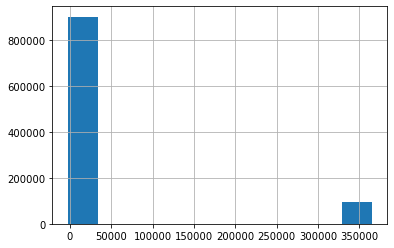

In [100]:
# Par rapport à la date de demande de la demande actuelle quand était la première échéance de la demande précédente
pre_appli['DAYS_LAST_DUE_1ST_VERSION'].hist()
print(pre_appli['DAYS_LAST_DUE_1ST_VERSION'].describe())
#print(pre_appli['DAYS_LAST_DUE_1ST_VERSION'].value_counts())

count    997149.000000
mean      76582.403064
std      149647.415123
min       -2889.000000
25%       -1314.000000
50%        -537.000000
75%         -74.000000
max      365243.000000
Name: DAYS_LAST_DUE, dtype: float64


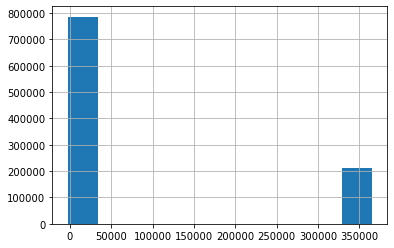

In [101]:
# PPar rapport à la date d'application de l'application actuelle quand était la dernière date 
# d'échéance de l'application précédente
pre_appli['DAYS_LAST_DUE'].hist()
print(pre_appli['DAYS_LAST_DUE'].describe())
#print(pre_appli['DAYS_LAST_DUE'].value_counts())

count    997149.000000
mean      81992.343838
std      153303.516729
min       -2874.000000
25%       -1270.000000
50%        -499.000000
75%         -44.000000
max      365243.000000
Name: DAYS_TERMINATION, dtype: float64


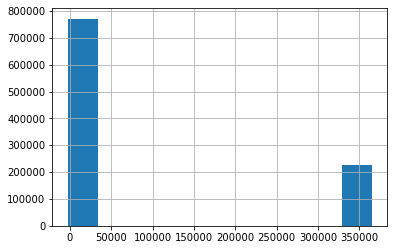

In [102]:
# Par rapport à la date de candidature de la candidature actuelle, quelle était la fin prévue 
# de la candidature précédente
pre_appli['DAYS_TERMINATION'].hist()
print(pre_appli['DAYS_TERMINATION'].describe())
#print(pre_appli['DAYS_TERMINATION'].value_counts())

In [292]:
# Par rapport à la date de candidature de la candidature actuelle, quelle était la fin prévue
pre_appli['APP_CREDIT_PERC'] = pre_appli['AMT_APPLICATION'] / pre_appli['AMT_CREDIT']
#pre_appli['APP_CREDIT_PERC'].hist()
print(pre_appli['APP_CREDIT_PERC'].describe())
#print(pre_appli['APP_CREDIT_PERC'].value_counts())

count    1.333446e+06
mean              inf
std               NaN
min      0.000000e+00
25%      8.959282e-01
50%      1.000000e+00
75%      1.011023e+00
max               inf
Name: APP_CREDIT_PERC, dtype: float64


In [103]:
# Sauvegarde avant imputation des valeurs manquantes
train = appli_train.copy()
test = appli_test.copy()
train.shape, test.shape

((307507, 127), (48744, 121))

### Imputation des valeurs manquantes

> On va remplancer les NaN par la médiane pour les variables correspondantes.

In [126]:
print('Nombre de valeurs manquantes dans le train: ', sum(appli_train.isnull().sum()))
print('Nombre de valeurs manquantes dans le test: ', sum(appli_test.isnull().sum()))

Nombre de valeurs manquantes dans le train:  9152465
Nombre de valeurs manquantes dans le test:  1404419


In [444]:
appli_train.isna().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

# II-Data cleaning & Feature engineering <a class="anchor" id="chapter2"></a>

##### [Table of Contents](#table1)

In [219]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [220]:
from sklearn.impute import SimpleImputer

# Imput missing values with SimpleImputer using 'mode' for categorical features
# and using 'median' for numerical features
def imput_nan(df):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    if categorical_columns:
        df[categorical_columns] = SimpleImputer(strategy='most_frequent').fit_transform(df[categorical_columns])    
    numerical_columns = [col for col in df.columns if (col not in categorical_columns) and (col not in ['SK_ID_CURR','TARGET'])]
    if numerical_columns:
        df[numerical_columns]  = SimpleImputer(strategy='median').fit_transform(df[numerical_columns])    
    return df

In [221]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [222]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(test = False, num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/application_train.csv', nrows= num_rows)
    if test :
        test_df = pd.read_csv('/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/application_test.csv', nrows= num_rows)
        print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
        df = df.append(test_df).reset_index(drop=True)
        del test_df
    else :
        print("Train samples: {}".format(len(df)))
    
    # Imputing Missing-values
    df = imput_nan(df)
    
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    gc.collect()
    return df

In [223]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/bureau_balance.csv', nrows = num_rows)
    # Imputing Missing-values
    bureau = imput_nan(bureau)
    bb = imput_nan(bb)
    
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['mean'],#['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['mean'],#['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['mean'],#['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['mean'],#['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['mean'],#['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean'],#['mean', 'sum'],
        'AMT_ANNUITY': ['mean'],#['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean']#['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [224]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/previous_application.csv', nrows = num_rows)
    prev = imput_nan(prev)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['mean'],#['min', 'max', 'mean'],
        'AMT_APPLICATION': ['mean'],#['min', 'max', 'mean'],
        'AMT_CREDIT': ['mean'],#['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['mean'],#['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['mean'],#['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['mean'],#['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['mean'],#['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['mean'],#['min', 'max', 'mean'],
        'DAYS_DECISION': ['mean'],#['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean']#['mean', 'sum'],
    }
    
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [225]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/POS_CASH_balance.csv', nrows = num_rows)
    pos = imput_nan(pos)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['mean'],#['max', 'mean', 'size'],
        'SK_DPD': ['mean'],#['max', 'mean'],
        'SK_DPD_DEF': ['mean']#: ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [226]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/installments_payments.csv', nrows = num_rows)
    ins = imput_nan(ins)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['mean'],#['max', 'mean', 'sum'],
        'DBD': ['mean'],#['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['mean'],#['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['mean'],#['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['mean'],#['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['mean'],#['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['mean']#['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [227]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('/Users/saidmazzi/openclassroom/Projet_7_Implémentez_un_modèle_de_scoring_112022/Projet_Mise_en_prod_home_credit_default_risk/credit_card_balance.csv', nrows = num_rows)
    cc = imput_nan(cc)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['mean'])#['min', 'max', 'mean', 'sum', 'var']
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [228]:
def main(test = False,debug = False):
    num_rows = 150000 if debug else None
    df = application_train_test(test,num_rows)
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        del bureau
        gc.collect()                  
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        del cc
        gc.collect()
    
    return df

In [245]:
data_main = main(test = True,debug = True)

Train samples: 150000, test samples: 48744
Bureau df shape: (34117, 74)
Process bureau and bureau_balance - done in 4s
Previous applications df shape: (110071, 187)
Process previous_applications - done in 8s
Pos-cash balance df shape: (104063, 11)
Process POS-CASH balance - done in 2s
Installments payments df shape: (58741, 9)
Process installments payments - done in 2s
Credit card balance df shape: (64370, 27)
Process credit card balance - done in 3s


In [246]:
data_main.shape

(198741, 555)

In [247]:
data_main.head(3)

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_SK_DPD_MEAN,CC_SK_DPD_DEF_MEAN,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Sentproposal_MEAN,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_COUNT
0,100002,1.0,0,0,0,0.0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0.0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0.0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [248]:
# valeurs manquantes
data_main.isnull().sum().sum()

47211171

In [249]:
test_index=data_main[data_main['TARGET'].isnull()].index
test_index

Int64Index([150000, 150001, 150002, 150003, 150004, 150005, 150006, 150007,
            150008, 150009,
            ...
            198734, 198735, 198736, 198737, 198738, 198739, 198740, 198741,
            198742, 198743],
           dtype='int64', length=48744)

In [250]:
import re
data_main = data_main.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
data_main[data_main==np.inf]=np.nan
data_main.fillna(data_main.median(), inplace=True)

In [251]:
#Split Target / other Features
X = data_main.drop(['SK_ID_CURR','TARGET'], axis=1)
y = data_main.TARGET
features_names = X.columns.tolist()

### Feature Selection with CORRELATION

In [252]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # features names
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection: 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in features_names]
    return cor_support, cor_feature

In [253]:
cor_support, cor_feature = cor_selector(X, y)

invalid value encountered in true_divide
invalid value encountered in true_divide


### Feature Selection with Random Forest

In [254]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='1.25*median').fit(X, y)
rf_support = rf_selector.get_support()
rf_feature = X.loc[:,rf_support].columns.tolist()

### Feature Selection with LightLGBM

In [255]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

lgb_selector = SelectFromModel(lgbc, threshold='1.25*median').fit(X, y)
lgb_support = lgb_selector.get_support()
lgb_feature = X.loc[:,lgb_support].columns.tolist()

### Summary

In [256]:
pd.set_option('display.max_rows', None)
# rassembler toute la together
feature_selection = pd.DataFrame({'Features':features_names,'Pearson':cor_support,
                                     'Random Forest':rf_support,'LightGBM':lgb_support})
# count the selected times for each feature
feature_selection['Total'] = np.sum(feature_selection, axis=1)
# display the top 100
feature_selection = feature_selection.sort_values(['Total','Features'] , ascending=False)
feature_selection.index = range(1, len(feature_selection)+1)

In [257]:
feature_selection[feature_selection.Total>=3]

,Features,Pearson,Random Forest,LightGBM,Total
1,TOTALAREA_MODE,True,True,True,3
2,REG_CITY_NOT_WORK_CITY,True,True,True,3
3,REG_CITY_NOT_LIVE_CITY,True,True,True,3
4,REGION_RATING_CLIENT_W_CITY,True,True,True,3
5,REGION_RATING_CLIENT,True,True,True,3
6,REGION_POPULATION_RELATIVE,True,True,True,3
7,PREV_PRODUCT_COMBINATION_CardStreet_MEAN,True,True,True,3
8,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,True,True,True,3
9,PREV_HOUR_APPR_PROCESS_START_MEAN,True,True,True,3
10,PREV_DAYS_DECISION_MEAN,True,True,True,3


In [258]:
selected_features = list(feature_selection[feature_selection.Total>=3]['Features'])

In [259]:
selected_features.extend(['SK_ID_CURR','TARGET'])

## Saving data

In [260]:
data_main.loc[test_index, ['TARGET']] = np.nan

In [261]:
#Data cleané
data_main.to_csv('data_main.csv',index=False)

In [262]:
#features selections cleané
df = data_main[selected_features]

In [263]:
df.to_csv('features_selected.csv',index=False)

In [264]:
#train cleané
train = df[df.TARGET.isnull() == False]
train.to_csv('data_train.csv',index=False)

In [265]:
#test cleané
test = df[df.TARGET.isnull()]
test.to_csv('data_test.csv',index=False)

On va reduire la taille du fichier brut pour pouvoir le commit dan

In [15]:
train_app = pd.read_csv("application_train.csv")
#On va échantillonner les données pour avoir un dataset
train_app = train_app.sample(180000, random_state=42)

In [16]:
train_app.to_csv('application_train_red.csv',index=False)